In [1]:
import csv
import sys
from pathlib import Path

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from scipy import stats
from skimage import (
    color,
    data,
    draw,
    exposure,
    feature,
    filters,
    graph,
    img_as_float,
    io,
    measure,
    morphology,
    restoration,
    segmentation,
    transform,
    util,
)

sys.path.append("..")

from mosquito.pylib import stripe, tile
from mosquito.pylib import tile_dataset as td

In [2]:
DATA_DIR = Path("..") / "data"
LAYER_DIR = DATA_DIR / "layers"
IMAGE_DIR = DATA_DIR / "junk"
TEST_DIR = DATA_DIR / "test"

STRIPE_CSV = DATA_DIR / "stripes.csv"

D_TIFF = LAYER_DIR / "dem.tif"
F_TIFF = LAYER_DIR / "fa.tif"
S_TIFF = LAYER_DIR / "slope.tif"
W_TIFF = LAYER_DIR / "wetness.tif"
L_TIFF = LAYER_DIR / "larv_spot_50m_correct.tif"

SMALL = 0.1
MED = 0.2

## For displaying images

In [3]:
def one_up(image):
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16, 16))
    ax.imshow(image)
    ax.axis("off")
    plt.show()

In [4]:
def one_gray(image):
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16, 16))
    ax.imshow(image, cmap=plt.cm.gray)
    ax.axis("off")
    plt.show()

## Get layer data

In [5]:
def image_data(path, target=False):
    data = td.prepare_image(path, target=target, zscore=False)

    lo, hi = data.min(), data.max()

    data -= lo
    data /= hi - lo

    return data

## Put stripes onto an already scaled image

In [6]:
def display_stripes(image, stripes, color):
    for s in stripes:
        l, r, t, b = s.beg, s.end, s.row, s.row + tile.TILE_SIZE + 1
        l, r, t, b = [round(x * SMALL) for x in (l, r, t, b)]
        rr, cc = draw.rectangle((t, l), end=(b, r))
        image[rr, cc] = color

## Get tiles from images of them

In [7]:
def get_tiles(image, mask):
    data = np.zeros_like(image)
    for path in TEST_DIR.glob(mask):
        with Image.open(path) as img:
            tile_ = np.array(img)
        *_, l, t, r, b = path.stem.split("_")
        l, t, r, b = int(l), int(t), int(r), int(b)
        data[t:b, l:r] = tile_
    return data

## Convert hex color notation into RGB notation

In [8]:
def rgb(h):
    h = h.lstrip("#")
    return tuple(int(h[i : i + 2], 16) for i in (0, 2, 4))

In [9]:
def rgba(h):
    h = h.lstrip("#")
    return tuple(int(h[i : i + 2], 16) for i in (0, 2, 4, 6))

## Read in the stripe data

In [10]:
with open(STRIPE_CSV) as f:
    reader = csv.DictReader(f)
    stripes = [s for s in reader]

test_stripes = stripe.filter_stripes(stripe.read_stripes(STRIPE_CSV, "test"))
val_stripes = stripe.filter_stripes(stripe.read_stripes(STRIPE_CSV, "val"))
train_stripes = stripe.filter_stripes(stripe.read_stripes(STRIPE_CSV, "train"))
len(test_stripes)

16

## Read in some layer data

In [11]:
w_data = image_data(W_TIFF)

l_data = image_data(L_TIFF, target=True)
l_data = np.squeeze(l_data)

In [27]:
w_data.shape

(41668, 19981)

In [12]:
w_small = transform.rescale(w_data, SMALL)
w_small = np.uint8(w_small * 255.0)

In [13]:
w_med = transform.rescale(w_data, MED)
w_med = np.uint8(w_med * 255.0)

In [14]:
l_small = transform.rescale(l_data, SMALL)
l_med = transform.rescale(l_data, MED)

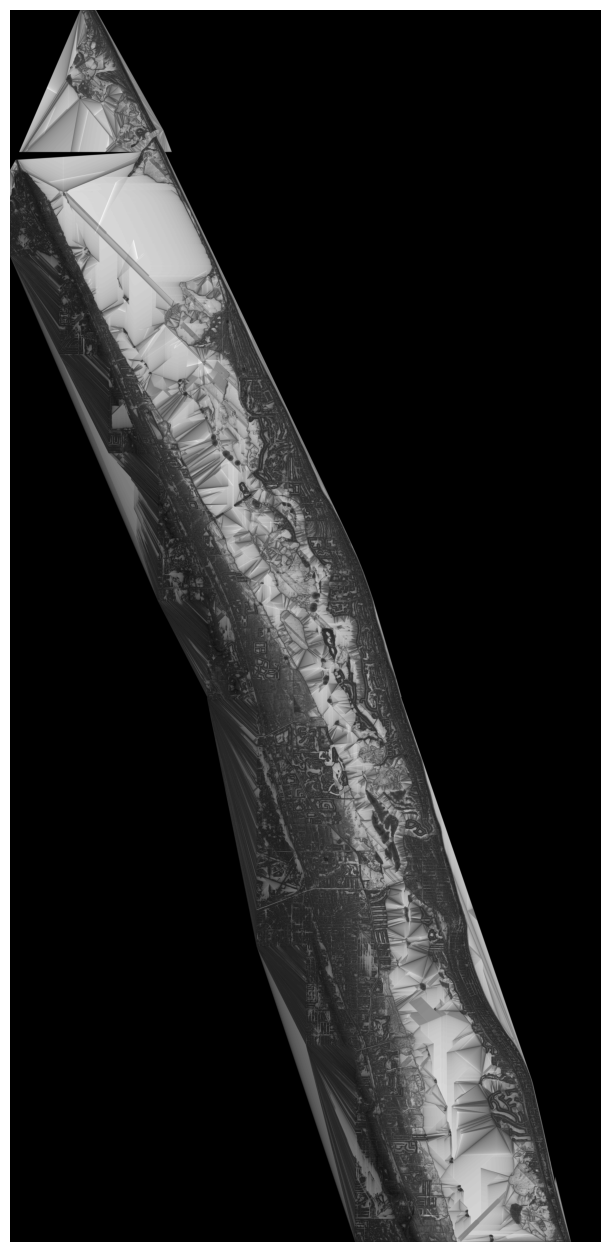

In [15]:
one_gray(w_small)
io.imsave(IMAGE_DIR / "one_layer.png", w_small)

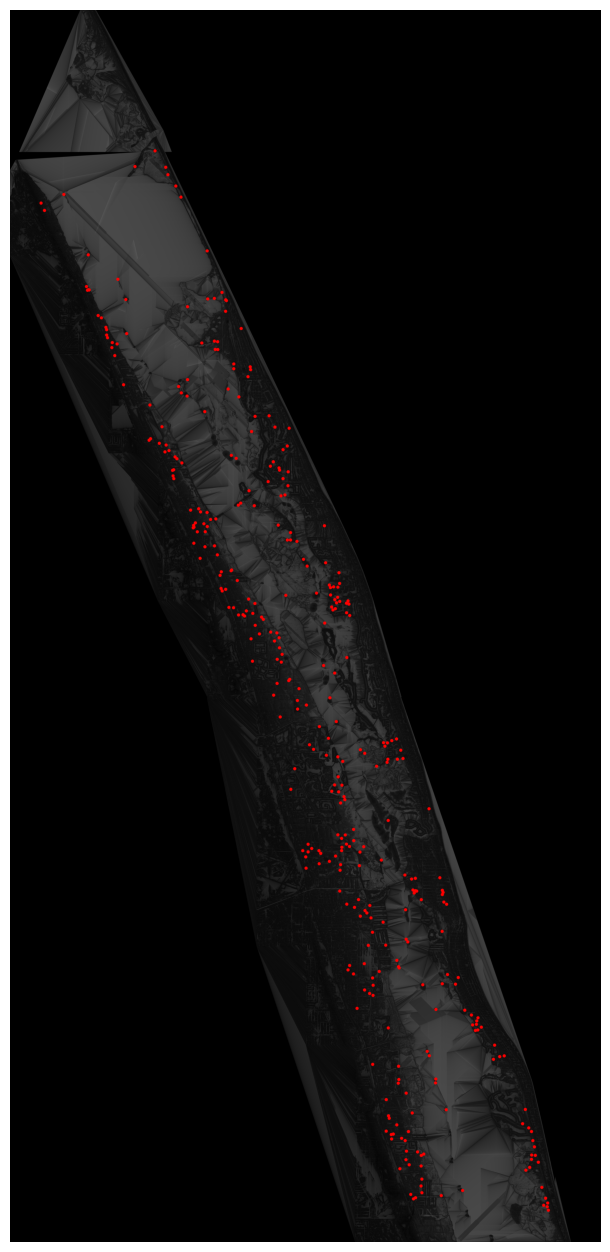

In [16]:
l_bool = l_med > 0.5

w_true = color.gray2rgb(w_med)
w_true[l_bool] = rgb("#ff0000aa")

one_up(w_true)
io.imsave(IMAGE_DIR / "true.png", w_true)

In [17]:
w_stripes = color.gray2rgb(w_small)

In [18]:
display_stripes(w_stripes, test_stripes, rgb("#ffa600ff"))
display_stripes(w_stripes, val_stripes, rgb("#7a5195ff"))
display_stripes(w_stripes, train_stripes, rgb("#003f5cff"))

In [19]:
w_stripes.shape, w_stripes.max(), w_stripes.dtype

((4167, 1998, 3), 255, dtype('uint8'))

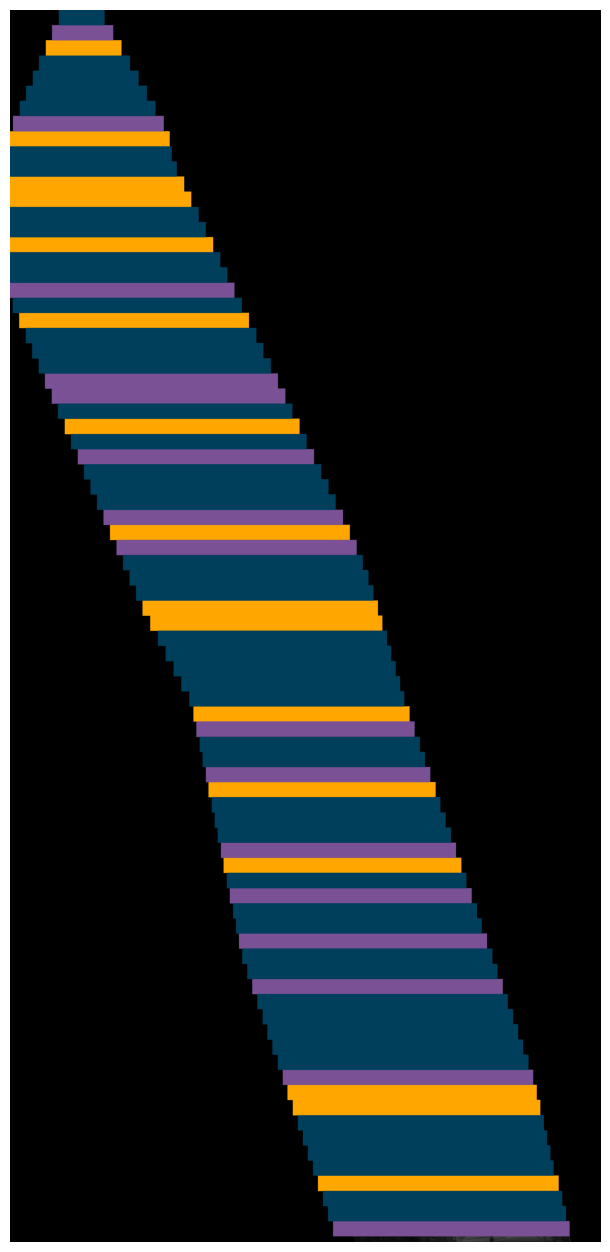

In [20]:
one_up(w_stripes)
io.imsave(IMAGE_DIR / "stripes.png", w_stripes)

In [21]:
p_data = get_tiles(l_data, "score_test_pred_*.jpg")
t_data = get_tiles(l_data, "score_test_true_*.jpg")

In [22]:
p_data = transform.rescale(p_data, MED)
t_data = transform.rescale(t_data, MED)

In [23]:
p_bool = p_data > 128.0
t_bool = t_data > 128.0

In [24]:
w_image = color.gray2rgba(w_med)

w_image[t_bool] = rgba("#ff0000aa")
w_image[p_bool] = rgba("#0000ffaa")

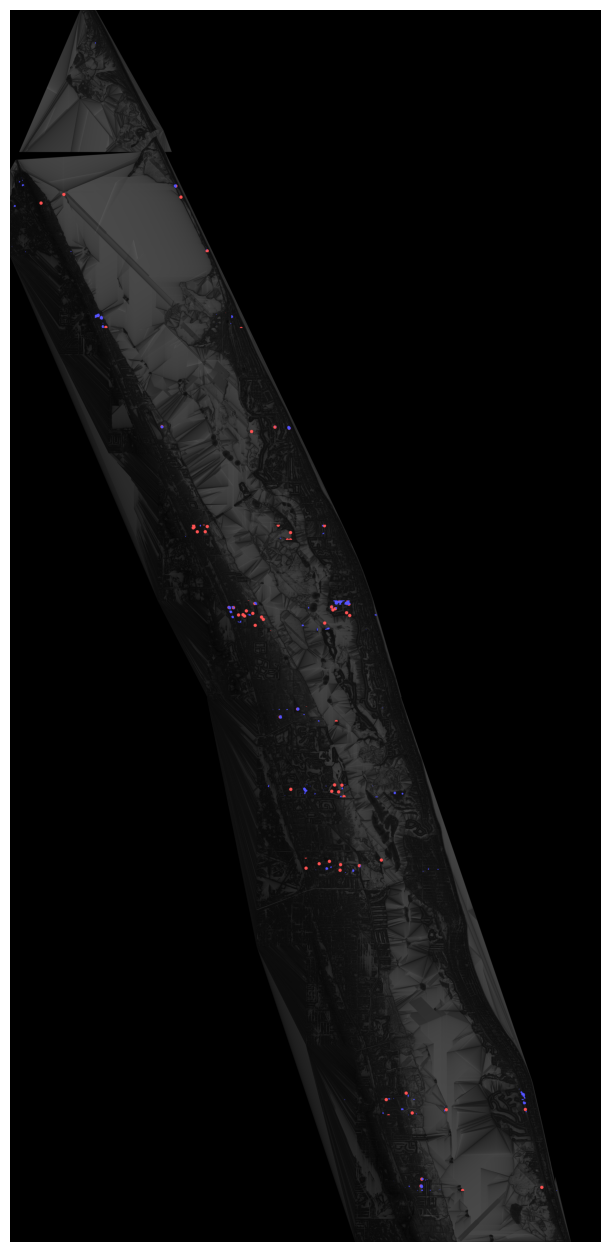

In [25]:
one_up(w_image)
io.imsave(IMAGE_DIR / "test_results.png", w_image)